# StackOverflow Developer Survey 2024 

**Business Understanding:**
The annual Stack Overflow Developer Survey provides insights into developer work environments, compensation, technology usage, and job satisfaction. The analysis in this notebook aims to identify key factors influencing developer job satisfaction in the 2024 dataset, offering actionable insights for companies and professionals.

**Key Questions:**
* How much does compensation impact job satisfaction?
* Does remote work influence job satisfaction?
* What other factors play a significant role?

**Data Understanding:**
The 2024 dataset consists of responses to 113 survey questions from 65,437 developers worldwide. However, many responses were voluntary, leading to a high proportion of missing data. The target variable, job satisfaction, is measured on a 0-10 scale, with 29,126 responses available.

**Data Preparation**
Since most responses are in textual format, they require transformation into numerical features for analysis. Survey responses are categorized into multi-choice and single-choice questions, with the latter further classified as ordinal or categorical. Due to extensive missing data and individual variability, only sufficiently populated features are retained, and rows with missing values in key variables are removed.

**Data Cleaning Steps:**
* Multi-choice responses: Converted into numerical counts of selected items.
* Single-choice responses: Encoded as ordinal or one-hot variables.
* Numerical responses: Standardized for comparability (e.g., currency values adjusted across countries).
* Missing data: Features with excessive missing values are excluded; remaining missing values are handled by row-wise deletion.

**Modeling:**
A Random Forest Regressor is trained to predict job satisfaction based on the processed features. GridSearchCV was leveraged for hyperparameter tuning.

**Evaluation:**
Model performance is assessed using Mean Squared Error (MSE). To interpret feature importance, both Random Forest feature rankings and SHAP values are analyzed.

**Insights Sharing:**
Key findings and actionable insights are shared in the following Medium blog post:

# Imports

Import all necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import currency_converter

# scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error

# Load Data

Two datasets will be loaded that contain the 2024 Stack Overflow Developer Survey questions and responses, respectively.

## Questionnaire Data

In [2]:
# Load questionnaire dataset
questions24_df = pd.read_csv('./stack-overflow-developer-survey-2024/survey_results_schema.csv')
print(questions24_df.shape)
questions24_df.head()

(87, 6)


,qid,qname,question,force_resp,type,selector
0,QID2,MainBranch,Which of the following options best describes ...,True,MC,SAVR
1,QID127,Age,What is your age?*,True,MC,SAVR
2,QID296,Employment,Which of the following best describes your cur...,True,MC,MAVR
3,QID308,RemoteWork,Which best describes your current work situation?,False,MC,SAVR
4,QID341,Check,Just checking to make sure you are paying atte...,True,MC,SAVR


In [3]:
# take a look at all question identifier + question pairs
questions24_df.apply(lambda row: (row['qname'] +": "+row['question']), axis=1).values

array(['MainBranch: Which of the following options best describes you today? For the purpose of this survey, a developer is "someone who writes code".*',
       'Age: What is your age?*',
       'Employment: Which of the following best describes your current employment status? Select all that apply.*',
       'RemoteWork: Which best describes your current work situation?',
       'Check: Just checking to make sure you are paying attention to the survey questions. Select ‘Apples’ from the list and you can get back to the survey.*<br><br>',
       'CodingActivities: Which of the following best describes the code you write outside of work? Select all that apply.',
       'EdLevel: Which of the following best describes the highest level of formal education that you’ve completed? *',
       'LearnCode: How do you learn to code? Select all that apply.',
       'LearnCodeOnline: What online resources do you use to learn to code? Select all that apply.',
       'TechDoc: What is the source of 

In [4]:
# Take a look at high impact questions
for q in ['Knowledge','Purchase', 'Frustration', 'ProfessionalTech', 'Frequency']:
    print(f"*************************************{q}*************************************")
    print(questions24_df.loc[questions24_df['qname'].str.startswith(q)][['qname','question']].values)

*************************************Knowledge*************************************
[['Knowledge'
  'Please rate your level of agreement with the following statement:']
 ['Knowledge_1'
  'I have interactions with people outside of my immediate team.']
 ['Knowledge_2'
  "Knowledge silos prevent me from getting ideas across the organization (i.e., one individual or team has information that isn't shared with others)"]
 ['Knowledge_3'
  'I can find up-to-date information within my organization to help me do my job.']
 ['Knowledge_4'
  'I am able to quickly find answers to my questions with existing tools and resources.']
 ['Knowledge_5'
  'I know which system or resource to use to find information and answers to questions I have.']
 ['Knowledge_6'
  'I often find myself answering questions that I’ve already answered before.']
 ['Knowledge_7'
  'Waiting on answers to questions often causes interruptions and disrupts my workflow.']
 ['Knowledge_8'
  "I feel like I have the tools and/or reso

## Survey Responses

In [5]:
# Load Stack Overflow 2024 Survey dataset 
survey24_df = pd.read_csv('./stack-overflow-developer-survey-2024/survey_results_public.csv',index_col='ResponseId')
# drop unwanted check column
survey24_df.drop('Check',inplace=True,axis=1)
# Shorten hybrid response in remote work column
survey24_df['RemoteWork'] = survey24_df['RemoteWork'].replace('Hybrid (some remote, some in-person)','Hybrid')
# Keep only abbreviaton for currency
survey24_df['Currency'] = survey24_df['Currency'].str.split(' ').str[0].str.split('\t').str[0]
# Look at dataset size
# Identify general info and column data types 
survey24_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65437 entries, 1 to 65437
Columns: 112 entries, MainBranch to JobSat
dtypes: float64(13), object(99)
memory usage: 56.4+ MB


In [6]:
# Investigate relationship between response columns and questions in questionnaire dataset based on question identifiers
print("****Columns linked to question names****")
print(survey24_df.columns[survey24_df.columns.isin(questions24_df['qname'].tolist())].tolist())
print()
print("****Columns NOT linked to question names****")
print(survey24_df.columns[~survey24_df.columns.isin(questions24_df['qname'].tolist())].tolist())
print()
print("****Questions NOT linked to column names****")
print(questions24_df.loc[~questions24_df['qname'].isin(survey24_df.columns.tolist()),'qname'].tolist())

****Columns linked to question names****
['MainBranch', 'Age', 'Employment', 'RemoteWork', 'CodingActivities', 'EdLevel', 'LearnCode', 'LearnCodeOnline', 'TechDoc', 'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize', 'PurchaseInfluence', 'BuyNewTool', 'BuildvsBuy', 'TechEndorse', 'Country', 'Currency', 'CompTotal', 'NEWSOSites', 'SOVisitFreq', 'SOAccount', 'SOPartFreq', 'SOHow', 'SOComm', 'AISelect', 'AISent', 'AIBen', 'AIAcc', 'AIComplex', 'AIThreat', 'AIEthics', 'AIChallenges', 'TBranch', 'ICorPM', 'WorkExp', 'Knowledge_1', 'Knowledge_2', 'Knowledge_3', 'Knowledge_4', 'Knowledge_5', 'Knowledge_6', 'Knowledge_7', 'Knowledge_8', 'Knowledge_9', 'Frequency_1', 'Frequency_2', 'Frequency_3', 'TimeSearching', 'TimeAnswering', 'Frustration', 'ProfessionalTech', 'ProfessionalCloud', 'ProfessionalQuestion', 'Industry', 'JobSatPoints_1', 'JobSatPoints_4', 'JobSatPoints_5', 'JobSatPoints_6', 'JobSatPoints_7', 'JobSatPoints_8', 'JobSatPoints_9', 'JobSatPoints_10', 'JobSatPoints_11', 'SurveyLength'

# Exploratory Data Analysis

## Survey data characteristics

TBranch                             2
ICorPM                              2
AISelect                            3
SurveyEase                          3
RemoteWork                          3
                                ...  
NEWCollabToolsHaveWorkedWith    14168
ToolsTechWantToWorkWith         16549
ToolsTechHaveWorkedWith         19883
LanguageWantToWorkWith          22769
LanguageHaveWorkedWith          23864
Length: 112, dtype: int64

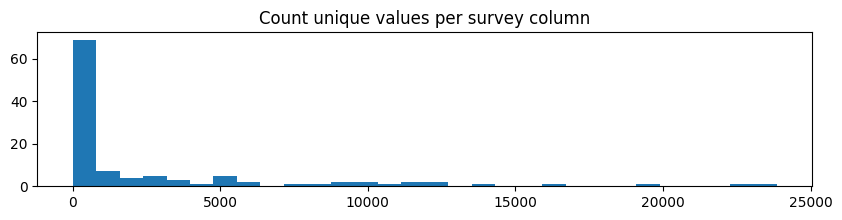

In [7]:
# Understand the number of unique values per column (because mostly text data)
nuniq_percol = survey24_df.nunique().sort_values()
display(nuniq_percol)
plt.figure(figsize=(10,2))
plt.hist(nuniq_percol,bins=30)
plt.title("Count unique values per survey column")
plt.show()

In [8]:
# Identify columns where multiple answers were possible
str_col_df = survey24_df.select_dtypes(include='object')
multi_choice_cols = str_col_df.loc[:,str_col_df.apply(lambda x: x.str.contains(";")).any()].columns.tolist()
# Count the number of unique values in each multiple choice column
print(f"There are {len(multi_choice_cols)} multi-choice columns.")
for col in multi_choice_cols:
    print(col,survey24_df[col].str.get_dummies(sep=";").shape[1])

There are 57 multi-choice columns.
Employment 9
CodingActivities 8
LearnCode 9
LearnCodeOnline 17
TechDoc 7
BuyNewTool 8
TechEndorse 9
LanguageHaveWorkedWith 49
LanguageWantToWorkWith 49
LanguageAdmired 49
DatabaseHaveWorkedWith 35
DatabaseWantToWorkWith 35
DatabaseAdmired 35
PlatformHaveWorkedWith 27
PlatformWantToWorkWith 27
PlatformAdmired 27
WebframeHaveWorkedWith 36
WebframeWantToWorkWith 36
WebframeAdmired 36
EmbeddedHaveWorkedWith 20
EmbeddedWantToWorkWith 20
EmbeddedAdmired 20
MiscTechHaveWorkedWith 39
MiscTechWantToWorkWith 39
MiscTechAdmired 39
ToolsTechHaveWorkedWith 34
ToolsTechWantToWorkWith 34
ToolsTechAdmired 34
NEWCollabToolsHaveWorkedWith 35
NEWCollabToolsWantToWorkWith 35
NEWCollabToolsAdmired 35
OpSysPersonal use 19
OpSysProfessional use 19
OfficeStackAsyncHaveWorkedWith 25
OfficeStackAsyncWantToWorkWith 25
OfficeStackAsyncAdmired 25
OfficeStackSyncHaveWorkedWith 23
OfficeStackSyncWantToWorkWith 23
OfficeStackSyncAdmired 23
AISearchDevHaveWorkedWith 25
AISearchDevWan

In [9]:
# Look into the amount of missing data
nan_vals_perc = survey24_df.isnull().sum().sort_values()/survey24_df.shape[0]
print("****Columns with less than 20% missing values****")
display(nan_vals_perc[nan_vals_perc<0.2])
print("****Columns with more than 50% missing values****")
display(nan_vals_perc[nan_vals_perc>0.5])

****Columns with less than 20% missing values****


MainBranch                       0.000000
Age                              0.000000
Employment                       0.000000
AISelect                         0.069227
EdLevel                          0.071107
LearnCode                        0.075630
NEWSOSites                       0.078717
YearsCode                        0.085089
LanguageHaveWorkedWith           0.086984
SOAccount                        0.089812
SOVisitFreq                      0.090178
DevType                          0.091569
SOComm                           0.095878
SOHow                            0.098950
Country                          0.099439
OpSysPersonal use                0.110992
NEWCollabToolsHaveWorkedWith     0.119886
SurveyEase                       0.140578
SurveyLength                     0.141434
LanguageWantToWorkWith           0.148005
OfficeStackSyncHaveWorkedWith    0.151168
RemoteWork                       0.162462
CodingActivities                 0.167657
OpSysProfessional use            0

****Columns with more than 50% missing values****


PlatformAdmired                  0.520501
AIToolInterested in Using        0.530984
ICorPM                           0.544585
WorkExp                          0.546770
MiscTechAdmired                  0.547718
JobSatPoints_9                   0.549857
JobSatPoints_8                   0.549857
JobSatPoints_10                  0.549949
JobSatPoints_6                   0.549949
JobSatPoints_7                   0.549979
JobSatPoints_11                  0.550025
JobSatPoints_5                   0.550545
JobSatPoints_4                   0.550820
JobSatPoints_1                   0.551874
JobSat                           0.554900
TimeSearching                    0.558186
Industry                         0.558996
TimeAnswering                    0.559210
ProfessionalQuestion             0.559775
Knowledge_1                      0.561960
ProfessionalCloud                0.564604
Frequency_1                      0.566469
Frequency_2                      0.566545
Frustration                      0

## Job Satisfaction

['How satisfied are you in your current professional developer role?']

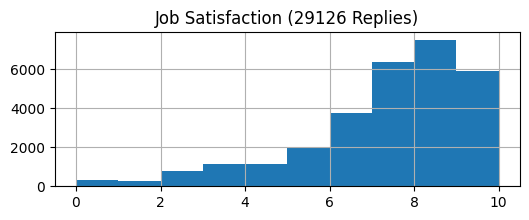

In [10]:
# Job Satisfaction Histogram
display(questions24_df.loc[questions24_df['qname']=='JobSat']['question'].tolist())
plt.figure(figsize=(6,2))
tmp = survey24_df['JobSat'].dropna()
tmp.hist()
plt.title(f"Job Satisfaction ({tmp.shape[0]} Replies)")
plt.show()

In [11]:
# Look at Job Satisfaction Points Questions
print(questions24_df.loc[questions24_df['qname']=='JobSatPoints','question'].values)
jobsat = questions24_df['qname'].str.startswith('JobSatPoints_')
jobsat_cols = questions24_df.loc[jobsat,'qname'].tolist()
print(questions24_df.loc[jobsat][['qname','question']].values)

['Assign points to the following attributes of your job according to those that contribute the most to your satisfaction out of 100 total points:']
[['JobSatPoints_1' 'Driving strategy for my team']
 ['JobSatPoints_4' 'Contributing to open source']
 ['JobSatPoints_5' 'Securing data and environments']
 ['JobSatPoints_6' 'Improving quality of code and developer environments']
 ['JobSatPoints_7'
  'Learning and using new technology, including platforms, APIs and libraries']
 ['JobSatPoints_8'
  'Designing and building environments, databases, and all things architecture']
 ['JobSatPoints_9'
  'Being a power user of a tool, developer language or process that others come to for answers and guidance about']
 ['JobSatPoints_10' 'Working with new and/or top-quality hardware']
 ['JobSatPoints_11'
  'A well-staffed/sourced internal network that makes observability easy so network or runtime issues are addressed and fixed easily']]


In [12]:
survey24_df.loc[:,jobsat_cols].describe()

,JobSatPoints_1,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11
count,29324.000000,29393.000000,29411.000000,29450.000000,29448.00000,29456.000000,29456.000000,29450.000000,29445.000000
mean,18.581094,7.522140,10.060857,24.343232,22.96522,20.278165,16.169432,10.955713,9.953948
std,25.966221,18.422661,21.833836,27.089360,27.01774,26.108110,24.845032,22.906263,21.775652
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,0.000000,0.000000,20.000000,15.00000,10.000000,5.000000,0.000000,0.000000
75%,22.000000,5.000000,10.000000,30.000000,30.00000,25.000000,20.000000,10.000000,10.000000
max,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000


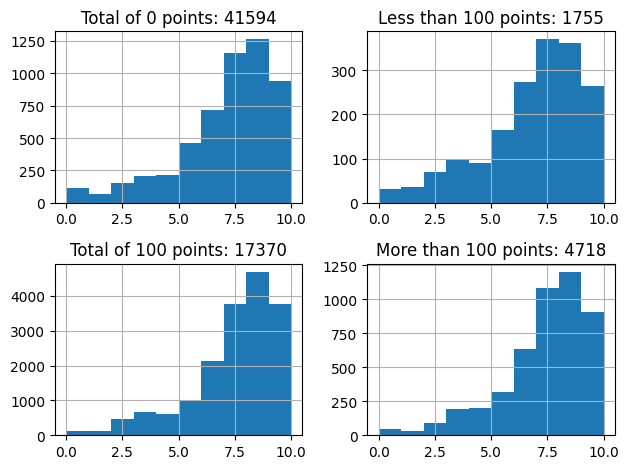

In [13]:
# Given the above instruction to assign 100 points total over JobSatPoints_1~11, check if most responses comply with this.
f, axs = plt.subplots(2, 2)

# Count answers with total of 0 points: 
cond1 = survey24_df[jobsat_cols].sum(1)==0
survey24_df.loc[cond1,'JobSat'].hist(ax=axs[0,0])
axs[0,0].set_title("Total of 0 points: %s"%cond1.sum())

# Count answers with less than 100 points:
cond2 = (survey24_df[jobsat_cols].sum(1)<100)&(survey24_df[jobsat_cols].sum(1)>0)
survey24_df.loc[cond2,'JobSat'].hist(ax=axs[0,1])
axs[0,1].set_title("Less than 100 points: %s"%cond2.sum())

# Count answers with exactly 100 points: 
cond3 = survey24_df[jobsat_cols].sum(1)==100
survey24_df.loc[cond3,'JobSat'].hist(ax=axs[1,0])
axs[1,0].set_title("Total of 100 points: %s"%cond3.sum())

# Count answers with more than 100 points: 
cond4 = survey24_df[jobsat_cols].sum(1)>100
survey24_df.loc[cond4,'JobSat'].hist(ax=axs[1,1])
axs[1,1].set_title("More than 100 points: %s"%cond4.sum())

plt.tight_layout()
plt.show()

**Assumption:** For responses with less than 100 total points, the job satisfaction is lower.

**Conclusion from Visualization:** Even for answers with less than 100 total points, the responded job satisfaction value is high in the majority of cases. This insight makes it difficult to interpret results (intention of low value responses). Therefore, the following analysis will only use responses that total to 100 points (for better data quality).

## Compensation

Investigate the available compensation information. The response was voluntary and there will be many missing values.

In [14]:
# Understand available compensation responses 
tmp_df = survey24_df[['CompTotal','JobSat','Currency']].dropna()
tmp_df.describe()

,CompTotal,JobSat
count,2.235700e+04,22357.000000
mean,4.472872e+145,6.930313
std,6.687953e+147,2.090986
min,0.000000e+00,0.000000
25%,6.000000e+04,6.000000
50%,1.100000e+05,7.000000
75%,2.550000e+05,8.000000
max,1.000000e+150,10.000000


In [15]:
# Count number of responses based on currency
tmp_df['Currency'].value_counts().head(20)

Currency
EUR    6297
USD    5690
GBP    1344
INR    1126
CAD     816
BRL     633
PLN     566
UAH     509
AUD     478
SEK     428
CHF     395
CZK     274
RUB     264
ILS     198
NOK     193
DKK     192
MXN     150
ZAR     150
NZD     140
HUF     139
Name: count, dtype: int64

### Convert Comps to USD

Convert all compensation information to USD based on the given currency information and remove extreme values.

In [16]:
from currency_converter import CurrencyConverter
from datetime import date

# load a currency converter
c = CurrencyConverter(fallback_on_missing_rate=True, fallback_on_wrong_date=True)

# filter to rows with known currency
currency_filter = tmp_df['Currency'].isin(c.currencies)
print(f"Number of data rows with unknown currency: {(~currency_filter).sum()}")
tmp_df=tmp_df.loc[currency_filter]

# generate currency conversion dictionary based on 2024 cutoff date
currency_dict = {'USD':1}
for currency in tmp_df['Currency'].unique().tolist():
    #print(currency)
    if not currency=='USD':
        currency_dict[currency]=c.convert(1, currency, 'USD', date=date(2024, 12, 31))
print("****** Used exchange rates for known currencies:******")
print(currency_dict)

# convert local compensation to USD
converted_comp = tmp_df.apply(lambda x: x['CompTotal']*currency_dict[x['Currency']], axis=1)
tmp_df['ConvComp'] = np.round(converted_comp,2)

# remove extrem values 
tmp_df=tmp_df[tmp_df['ConvComp']<tmp_df['ConvComp'].quantile(.99)]

# add converted compensation to survey dataset
survey24_df['USD_Compensation'] = tmp_df['ConvComp']

Number of data rows with unknown currency: 1951
****** Used exchange rates for known currencies:******
{'USD': 1, 'EUR': 1.0389, 'GBP': 1.2529245760872187, 'ZAR': 0.052954309132057, 'CZK': 0.041250744490768314, 'CAD': 0.695009365801445, 'BRL': 0.1616889483759513, 'RUB': 0.008864258837381933, 'INR': 0.011681762215588053, 'TRY': 0.02827923739424888, 'CHF': 1.1038036549086272, 'JPY': 0.006371274377529743, 'SEK': 0.09066236146260581, 'PLN': 0.2430175438596491, 'NOK': 0.08807969478592623, 'RON': 0.2088535070261142, 'ILS': 0.27422462716114554, 'HUF': 0.0025255864835298405, 'IDR': 6.176252372051878e-05, 'DKK': 0.13930381613880768, 'MXN': 0.04820792189472121, 'BGN': 0.5311892831577871, 'MYR': 0.22364059069186717, 'AUD': 0.6194252325304077, 'NZD': 0.5605978847399093, 'KRW': 0.0006780667689194922, 'PHP': 0.01722857000713089, 'CNY': 0.1369984043885907, 'THB': 0.029120417087117385, 'HKD': 0.12875839674788686, 'SGD': 0.733479243151652, 'ISK': 0.007219596942321056}


### Comp VS. Job Satisfaction?

Can we visually observe any relationship between compesation and job satisfaction?

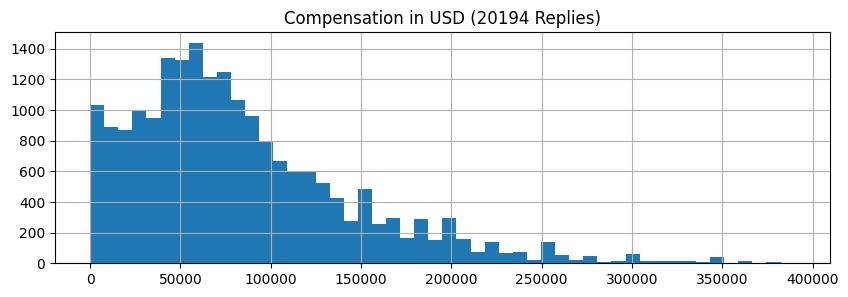

In [17]:
# show compensation distribution in USD
tmp_df['ConvComp'].hist(figsize=(10,3),bins=50)
plt.title(f"Compensation in USD ({tmp_df.shape[0]} Replies)")
plt.show()

,ConvComp,JobSat
ConvComp,1.000000,0.077245
JobSat,0.077245,1.000000


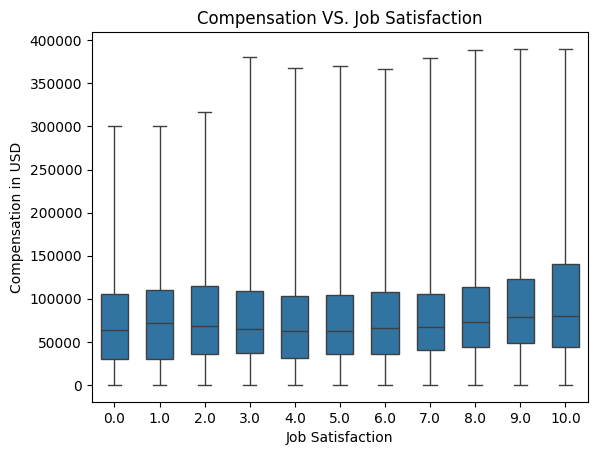

In [18]:
# correlation between job satisfaction and compensation
tmp_corr = tmp_df[['ConvComp','JobSat']].corr()
display(tmp_corr)
#
sns.boxplot(
    tmp_df, x="JobSat", y="ConvComp", 
    whis=[0, 100], width=.6
)
plt.xlabel("Job Satisfaction")
plt.ylabel("Compensation in USD")
plt.title('Compensation VS. Job Satisfaction')
plt.show()

In [19]:
# Currency based correlation between job satisfaction and compensation
tmp_dict = {}
for curr in tmp_df["Currency"].unique():
    tmp = tmp_df[tmp_df["Currency"]==curr]
    tmp_dict[curr]=[(tmp[["JobSat","ConvComp"]].corr().iloc[0,1]), tmp.shape[0]]

pd.Series(tmp_dict).sort_values()

ISK      [-0.16264471938251585, 11]
CNY       [-0.0652202448295096, 77]
NOK    [-0.024794011215913254, 193]
IDR      [-0.02193147263179911, 94]
RON     [0.011558119276880203, 117]
MYR      [0.012917000039743623, 57]
CZK      [0.05230703656194602, 274]
PHP       [0.06710910390431415, 44]
USD     [0.06952322494569094, 5526]
GBP     [0.07231353478055712, 1336]
SEK      [0.07419279359446676, 428]
INR      [0.0822877441167097, 1124]
CHF      [0.09120548328108281, 393]
EUR     [0.09368573477407632, 6284]
HUF      [0.10264633470452811, 139]
PLN      [0.10607660365015395, 566]
DKK      [0.10756648808661579, 191]
TRY      [0.11551134239010694, 129]
THB       [0.11659279736119446, 38]
MXN      [0.11909704964408667, 150]
NZD      [0.11925729740051512, 140]
CAD       [0.1321447577370931, 812]
RUB      [0.13936775979865437, 263]
BRL      [0.14322611958093148, 629]
AUD      [0.14562290379274476, 474]
ILS      [0.16557750860567522, 195]
HKD       [0.19519261408519673, 43]
BGN      [0.2146106680383293

## Remote Work

Can we visually observe any relationship between remote work and job satisfaction?

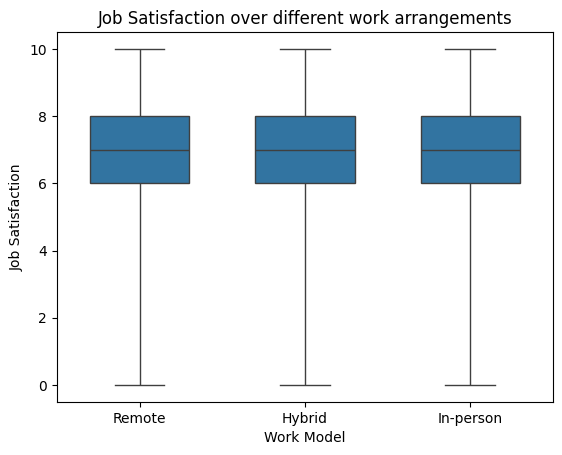

In [20]:
sns.boxplot(
    survey24_df[['RemoteWork','JobSat']].dropna(), x="RemoteWork", y="JobSat", 
    whis=[0, 100], width=.6
)
plt.title("Job Satisfaction over different work arrangements")
plt.ylabel("Job Satisfaction")
plt.xlabel("Work Model")
plt.show()

# Target Data Preparation

In [21]:
def process_jobsatpoints(df):
    """
    Preprocesses job satisfaction point distribution columns in the dataset.

    This function filters the dataset to include only rows where job satisfaction 
    point values are available and sum to 100. It identifies relevant columns 
    based on the prefix 'JobSatPoints_'.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing job satisfaction point distribution columns.

    Returns
    -------
    pandas.DataFrame
        Filtered DataFrame where job satisfaction point columns are complete and sum to 100.
    """

    jobsat_cols = df.columns[df.columns.str.startswith('JobSatPoints_')].tolist()
    df = df.loc[~df[jobsat_cols].isnull().all(1)]
    df = df[df[jobsat_cols].sum(1)==100]
    #df[jobsat_cols] = df[jobsat_cols].div(df[jobsat_cols].sum(1),axis=0)
    
    return df  

In [22]:
# Narrow down dataframe to rows where target variable is available
print(survey24_df.shape)
jobsat_df = survey24_df.loc[survey24_df['JobSat'].dropna().index]
print(jobsat_df.shape)

# Process job satisfaction related questions and drop rows with missing values
jobsat_df = process_jobsatpoints(jobsat_df)
print(jobsat_df.shape)

# Drop columns of less interest
no_interest_cols = [
                    'SurveyEase', 'SurveyLength', 'OpSysPersonal use', 'TBranch','NEWSOSites','SOHow',
                     'DevType', 'EdLevel', 'CompTotal','Currency','ConvertedCompYearly'
                    #'NEWCollabToolsHaveWorkedWith', 'OfficeStackSyncHaveWorkedWith', 'ICorPM',
                    #'SOAccount', 'AISelect',  'Industry', 'ProfessionalQuestion', 'MainBranch'
                   ]  
jobsat_df.drop(no_interest_cols,axis=1,inplace=True)
print(jobsat_df.shape)

# Drop missing rows for 'USD_Compensation' column
# Note: USD compensation information is only avaiable after executing EDA/Compensation/Convert Comps to USD
jobsat_df.dropna(subset=['USD_Compensation'], inplace=True)
print(jobsat_df.shape)

# Drop all columns that still have 500 or more missing values
many_nan_cols = jobsat_df.loc[:,jobsat_df.isnull().sum().sort_values()>500].columns.tolist()
#display(jobsat_df.loc[:,many_nan_cols].isnull().sum())
jobsat_df.drop(many_nan_cols,axis=1,inplace=True)
print(jobsat_df.shape)

# Final drop of rows with missing values
jobsat_df.dropna(inplace=True)
print(jobsat_df.shape)

(65437, 113)
(29126, 113)
(17359, 113)
(17359, 102)
(13409, 102)
(13409, 52)
(11632, 52)


In [23]:
jobsat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11632 entries, 390 to 65167
Data columns (total 52 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MainBranch                     11632 non-null  object 
 1   Age                            11632 non-null  object 
 2   Employment                     11632 non-null  object 
 3   RemoteWork                     11632 non-null  object 
 4   CodingActivities               11632 non-null  object 
 5   LearnCode                      11632 non-null  object 
 6   YearsCode                      11632 non-null  object 
 7   YearsCodePro                   11632 non-null  object 
 8   OrgSize                        11632 non-null  object 
 9   PurchaseInfluence              11632 non-null  object 
 10  BuyNewTool                     11632 non-null  object 
 11  TechEndorse                    11632 non-null  object 
 12  Country                        11632 non-null  ob

# Data Preprocessing Pipelines

## Custom Transformer Definitions

In [24]:
class PreTransform(BaseEstimator, TransformerMixin):
    """
    A custom transformer for preprocessing responses in the survey dataset.

    This transformer converts categorical experience values in the 'YearsCode' and 'YearsCodePro' 
    columns to numeric values. Specifically, it replaces:
    - 'Less than 1 year' with 0
    - 'More than 50 years' with 50
    and then converts the column to an integer type.

    This class follows the scikit-learn transformer API, making it compatible with pipelines.

    Attributes
    ----------
    None

    Methods
    -------
    fit(X, y=None)
        Returns the transformer instance (no fitting required).
    
    transform(X)
        Transforms the 'YearsCode' and 'YearsCodePro' columns to numeric values.

    """

    def fit(self, X, y=None):
        """
        Fit method for the transformer.

        Since this transformer does not learn from the data, it simply returns itself.

        Parameters
        ----------
        X : pandas.DataFrame
            Input dataset (not used in fitting).
        y : None, optional
            Ignored, present for compatibility with scikit-learn API.

        Returns
        -------
        PreTransform
            The transformer instance.
        """
        
        return self

    def transform(self, X):
        """
        Transforms the 'YearsCode' and 'YearsCodePro' columns into numeric values.

        This method modifies a copy of the input DataFrame by replacing categorical experience 
        values with numerical equivalents and converting the column type to integer.

        Parameters
        ----------
        X : pandas.DataFrame
            Input dataset containing the columns 'YearsCode' and 'YearsCodePro' (if present).

        Returns
        -------
        pandas.DataFrame
            Transformed DataFrame with updated 'YearsCode' and 'YearsCodePro' columns.
        """
        
        X = X.copy()

        for col in ['YearsCode', 'YearsCodePro']:
            if col in X.columns:
                X.loc[X[col]=='Less than 1 year',col] = 0
                X.loc[X[col]=='More than 50 years',col] = 50
                X[col] = X[col].astype(int)

        return X

In [25]:
class MultiCatTransform(BaseEstimator, TransformerMixin):

    """
    A custom transformer for processing multi-category textual columns in the survey dataset.

    This transformer processes columns where multiple categorical values are stored in a single 
    string field (e.g., 'Python;Java;C++'). It applies one-hot encoding using `str.get_dummies()` 
    and generates a new feature representing the total number of selected categories per row.

    This class follows the scikit-learn transformer API, making it compatible with pipelines.

    Attributes
    ----------
    data : pandas.DataFrame
        Stores the transformed DataFrame after applying multi-category encoding.

    Methods
    -------
    fit(X, y=None)
        Returns the transformer instance (no fitting required).
    
    transform(X)
        Applies multi-category transformation on all columns in the dataset.
    
    multicat_process_col(X, col, sep=';')
        Processes a single column, applying one-hot encoding and computing a sum feature.
    
    get_feature_names_out(input_features=None)
        Returns the feature names of the transformed columns.
    """

    def fit(self, X, y=None):
        """
        Fit method for the transformer.

        Since this transformer does not learn from the data, it simply returns itself.

        Parameters
        ----------
        X : pandas.DataFrame
            Input dataset (not used in fitting).
        y : None, optional
            Ignored, present for compatibility with scikit-learn API.

        Returns
        -------
        MultiCatTransform
            The transformer instance.
        """
        return self


    def transform(self, X):
        """
        Transforms all columns in the dataset by applying multi-category encoding.

        This method processes each column by splitting multi-category values using `str.get_dummies()`
        and adding a new feature that represents the total number of selected categories.

        Parameters
        ----------
        X : pandas.DataFrame
            Input dataset where columns contain multiple categorical values as strings.

        Returns
        -------
        pandas.DataFrame
            Transformed DataFrame where each column has been replaced with its sum feature.
        """
        cols_to_transform = list(X.columns)

        enc_dict = {}
        for col in cols_to_transform:
            enc_dict[col] = self.multicat_process_col(X,col)

        multi_col_df=pd.concat(enc_dict,axis=1)
        self.data = multi_col_df
            
        return multi_col_df


    def multicat_process_col(self,X,col,sep=';'):
        """
        Processes a single column containing multiple categorical values in a string format.

        This method applies one-hot encoding using `str.get_dummies()` and creates a new column
        that counts the number of selected categories per row.

        Parameters
        ----------
        X : pandas.DataFrame
            Input dataset containing the column to be processed.
        col : str
            The name of the column to process.
        sep : str, optional (default=';')
            The separator used to split multiple categories within the column.

        Returns
        -------
        pandas.DataFrame
            A DataFrame with a single column storing the count of selected categories per row.
        """
        tmp_df = X[col].str.get_dummies(sep=sep)
        tmp_df['sum_'+col] = tmp_df.sum(1)
    
        return tmp_df[['sum_'+col]]

    def get_feature_names_out(self, input_features=None):
        """
        Returns the feature names of the transformed dataset.

        Parameters
        ----------
        input_features : array-like, optional
            Ignored, present for compatibility with scikit-learn API.

        Returns
        -------
        list
            List of column names from the transformed DataFrame.
        """
        return self.data.columns.get_level_values(1).tolist()

## Define pipelines

Assign data columns to their respective data type and define preprocessing pipeline to handle the data encoding

In [26]:
target_col = 'JobSat'

# identify list of multi-choice columns
print("****Multi-choice columns****")
str_col_df = jobsat_df.select_dtypes(include='object')
multi_choice_cols = str_col_df.loc[:,str_col_df.apply(lambda x: x.str.contains(";")).any()].columns.tolist()
jobsat_multi_cols = [col for col in jobsat_df.columns if col in multi_choice_cols]
print(jobsat_multi_cols)

# identify list of single choice columns
print("****Single choice columns****")
jobsat_single_cols = [col for col in jobsat_df.select_dtypes(include='object').columns if col not in jobsat_multi_cols]
for col in ['Country','YearsCode','YearsCodePro']:
    jobsat_single_cols.remove(col)
print(jobsat_single_cols)

# Provide ordinal information to ensure accurate preprocessing
ordinal_dict = {
    'Knowledge_': ['Strongly disagree','Disagree','Neither agree nor disagree','Agree','Strongly agree'],
    'Frequency_': ['Never', '1-2 times a week', '3-5 times a week', '6-10 times a week', '10+ times a week'],
    'Time': ['Less than 15 minutes a day', '15-30 minutes a day', '30-60 minutes a day', '60-120 minutes a day', 'Over 120 minutes a day'],
    'PurchaseInfluence': ['I have little or no influence', 'I have some influence', 'I have a great deal of influence'],
    'Age': ['Under 18 years old', '18-24 years old', '25-34 years old', '35-44 years old', '45-54 years old', '55-64 years old', '65 years or older'], #, 'Prefer not to say'
    'OrgSize': ['Just me - I am a freelancer, sole proprietor, etc.','2 to 9 employees','10 to 19 employees','20 to 99 employees',
               '100 to 499 employees','500 to 999 employees','1,000 to 4,999 employees','5,000 to 9,999 employees','10,000 or more employees'], #, 'I don’t know'
    'SOComm': ['No, not at all', 'No, not really', 'Neutral', 'Yes, somewhat', 'Yes, definitely'],
    'SOVisitFreq': ['Less than once per month or monthly', 'A few times per month or weekly', 'A few times per week', 'Daily or almost daily', 'Multiple times per day']
}

ordinal_nan_dict = {
    'Age': 'Prefer not to say',
    'OrgSize': 'I don’t know',
}

# identify list of columns that are ordinal
categories_lst = []
ordinal_cols = list()
for key, val in ordinal_dict.items():
    tmp_df = jobsat_df.loc[:,jobsat_df.columns.str.startswith(key)]
    tmp_lst = [val] * tmp_df.shape[1]
    categories_lst.extend(tmp_lst)
    ordinal_cols.extend(tmp_df.columns.tolist())

print("****Ordinal columns****")
print(ordinal_cols)

# identify columns that need to be one-hot encoded
print("****One hot columns****")
single_cat_cols = [c for c in jobsat_single_cols if c not in ordinal_cols]

display(jobsat_df[single_cat_cols].nunique())

# identify numerical columns
print("****Numerical columns****")
number_cols = jobsat_df.columns[~(jobsat_df.columns.isin(jobsat_single_cols)|jobsat_df.columns.isin(jobsat_multi_cols)|jobsat_df.columns.isin(["Country",target_col]))].tolist()
print(number_cols)

****Multi-choice columns****
['Employment', 'CodingActivities', 'LearnCode', 'BuyNewTool', 'TechEndorse', 'LanguageHaveWorkedWith', 'NEWCollabToolsHaveWorkedWith', 'OfficeStackSyncHaveWorkedWith', 'Frustration', 'ProfessionalTech']
****Single choice columns****
['MainBranch', 'Age', 'RemoteWork', 'OrgSize', 'PurchaseInfluence', 'SOVisitFreq', 'SOAccount', 'SOComm', 'AISelect', 'ICorPM', 'Knowledge_1', 'Knowledge_2', 'Knowledge_3', 'Knowledge_4', 'Knowledge_5', 'Knowledge_6', 'Knowledge_7', 'Knowledge_8', 'Knowledge_9', 'Frequency_1', 'Frequency_2', 'Frequency_3', 'TimeSearching', 'TimeAnswering', 'ProfessionalCloud', 'ProfessionalQuestion', 'Industry']
****Ordinal columns****
['Knowledge_1', 'Knowledge_2', 'Knowledge_3', 'Knowledge_4', 'Knowledge_5', 'Knowledge_6', 'Knowledge_7', 'Knowledge_8', 'Knowledge_9', 'Frequency_1', 'Frequency_2', 'Frequency_3', 'TimeSearching', 'TimeAnswering', 'PurchaseInfluence', 'Age', 'OrgSize', 'SOComm', 'SOVisitFreq']
****One hot columns****


MainBranch               2
RemoteWork               3
SOAccount                3
AISelect                 3
ICorPM                   2
ProfessionalCloud        3
ProfessionalQuestion     9
Industry                15
dtype: int64

****Numerical columns****
['YearsCode', 'YearsCodePro', 'WorkExp', 'JobSatPoints_1', 'JobSatPoints_4', 'JobSatPoints_5', 'JobSatPoints_6', 'JobSatPoints_7', 'JobSatPoints_8', 'JobSatPoints_9', 'JobSatPoints_10', 'JobSatPoints_11', 'USD_Compensation']


In [27]:
# Define preprocessing pipeline for each data type
col_transformer = ColumnTransformer([
    ("multi_cat", MultiCatTransform(), jobsat_multi_cols),
    ("ordinal_cat", OrdinalEncoder(categories=categories_lst,handle_unknown='use_encoded_value',unknown_value=np.nan),ordinal_cols), 
    ("one_hot_cat", OneHotEncoder(sparse_output=False,max_categories=5), single_cat_cols),
    ("country_enc", OrdinalEncoder(max_categories=30,handle_unknown='use_encoded_value',unknown_value=np.nan), ['Country']),
    ("num_enc","passthrough",number_cols)
])

# Define overall data preprocessing pipeline
preprocess_pipeline = Pipeline([
    ('initial_preprocess',PreTransform()),
    ('column_transform',col_transformer),
    #('drop_missing', FunctionTransformer(dropna))
    ('simple_impute', SimpleImputer(strategy='most_frequent')),
    #('pca', PCA(n_components=30))
])

In [28]:
# test preprocessing pipeline
preprocess_pipeline.fit(jobsat_df)
processed_df = pd.DataFrame(preprocess_pipeline.transform(jobsat_df), columns=preprocess_pipeline[1].get_feature_names_out())
processed_df['JobSat'] = jobsat_df['JobSat'].values

## Job Satisfaction Correlation 

In [29]:
# Calculate correlations between preprocessed features
tmp_corr_df = processed_df.corr()
print("***********Top 15 negative correlated with job satisfaction***********")
display(tmp_corr_df['JobSat'].sort_values().head(15))
print("***********Top 15 positive correlated with job satisfaction***********")
display(tmp_corr_df['JobSat'].sort_values(ascending=False).iloc[1:].head(15))

***********Top 15 negative correlated with job satisfaction***********


ordinal_cat__Frequency_3                                    -0.259906
ordinal_cat__Knowledge_2                                    -0.249181
ordinal_cat__Knowledge_7                                    -0.214495
multi_cat__sum_Frustration                                  -0.183328
ordinal_cat__Knowledge_6                                    -0.128275
ordinal_cat__TimeSearching                                  -0.127075
ordinal_cat__OrgSize                                        -0.073952
one_hot_cat__ICorPM_Individual contributor                  -0.067118
num_enc__JobSatPoints_11                                    -0.043125
ordinal_cat__TimeAnswering                                  -0.040882
one_hot_cat__ProfessionalCloud_Hybrid (on-prem and cloud)   -0.038446
one_hot_cat__ProfessionalCloud_On-prem                      -0.038241
one_hot_cat__Industry_infrequent_sklearn                    -0.035046
ordinal_cat__Frequency_1                                    -0.033408
one_hot_cat__SOAccou

***********Top 15 positive correlated with job satisfaction***********


ordinal_cat__Knowledge_8              0.307889
ordinal_cat__Knowledge_3              0.304162
ordinal_cat__Knowledge_4              0.298634
ordinal_cat__Knowledge_5              0.250649
ordinal_cat__PurchaseInfluence        0.207278
multi_cat__sum_ProfessionalTech       0.136524
ordinal_cat__Knowledge_1              0.133289
num_enc__YearsCodePro                 0.100492
num_enc__WorkExp                      0.091828
num_enc__YearsCode                    0.091209
ordinal_cat__SOComm                   0.089022
ordinal_cat__Knowledge_9              0.081570
num_enc__JobSatPoints_1               0.069519
ordinal_cat__Age                      0.068813
one_hot_cat__ICorPM_People manager    0.067118
Name: JobSat, dtype: float64

# Train Models

## Data Split (Training/Test)

In [30]:
processed_df = jobsat_df

y_col = 'JobSat'
y = processed_df[y_col]
display(y.head(3))

X = processed_df.drop([y_col],axis=1)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

ResponseId
390    10.0
399     5.0
416     3.0
Name: JobSat, dtype: float64

(11632, 51)
(9305, 51)


## Random Forest Regressor

In [31]:
rf_reg_pipe = make_pipeline(preprocess_pipeline, RandomForestRegressor(random_state=42, max_depth=20, max_features=0.4, 
                                                                       min_samples_leaf=5, min_samples_split=2, n_estimators=500))
rf_reg_pipe.fit(X_train, y_train)
y_pred_test = rf_reg_pipe.predict(X_test)
print(mean_squared_error(y_test.values,y_pred_test))
print(root_mean_squared_error(y_test.values,(y_pred_test)))

2.956549858655083
1.7194620840992927


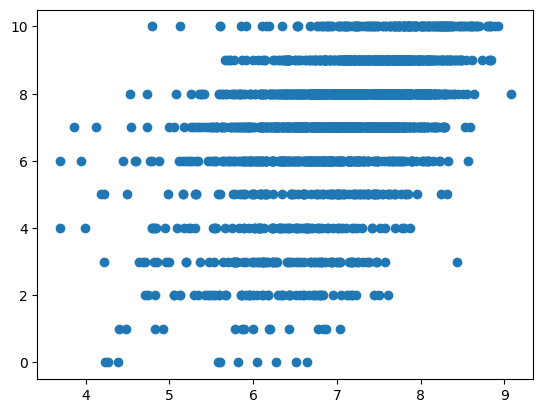

In [32]:
plt.scatter(x=y_pred_test,y=y_test)

### Hyperparameter GridSearch

In [33]:
rf_reg_pipe = make_pipeline(preprocess_pipeline, RandomForestRegressor(random_state=42))

param_grid = {
    'randomforestregressor__n_estimators': [200, 500, 1000],
    'randomforestregressor__max_depth': [20],
    'randomforestregressor__min_samples_split': [2],
    'randomforestregressor__min_samples_leaf': [5, 10],
    'randomforestregressor__max_features': [0.4, 0.6, 0.8],
}

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(rf_reg_pipe, param_grid, cv=5, verbose=2, return_train_score=True, scoring='neg_mean_squared_error')
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END randomforestregressor__max_depth=20, randomforestregressor__max_features=0.4, randomforestregressor__min_samples_leaf=5, randomforestregressor__min_samples_split=2, randomforestregressor__n_estimators=200; total time=   4.2s
[CV] END randomforestregressor__max_depth=20, randomforestregressor__max_features=0.4, randomforestregressor__min_samples_leaf=5, randomforestregressor__min_samples_split=2, randomforestregressor__n_estimators=200; total time=   4.3s
[CV] END randomforestregressor__max_depth=20, randomforestregressor__max_features=0.4, randomforestregressor__min_samples_leaf=5, randomforestregressor__min_samples_split=2, randomforestregressor__n_estimators=200; total time=   4.2s
[CV] END randomforestregressor__max_depth=20, randomforestregressor__max_features=0.4, randomforestregressor__min_samples_leaf=5, randomforestregressor__min_samples_split=2, randomforestregressor__n_estimators=200; total time=   4.2s
[CV

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('initial_preprocess',
                                                         PreTransform()),
                                                        ('column_transform',
                                                         ColumnTransformer(transformers=[('multi_cat',
                                                                                          MultiCatTransform(),
                                                                                          ['Employment',
                                                                                           'CodingActivities',
                                                                                           'LearnCode',
                                                                                           'BuyNewTool',
                                                                                           'TechEndorse',
                                                                                           'LanguageHaveWorkedWith',
                                                                                           'NEWCollabToolsHaveWorkedWith',
                                                                                           'OfficeStackSyncHaveWorkedW...
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'randomforestregressor__max_depth': [20],
                         'randomforestregressor__max_features': [0.4, 0.6, 0.8],
                         'randomforestregressor__min_samples_leaf': [5, 10],
                         'randomforestregressor__min_samples_split': [2],
                         'randomforestregressor__n_estimators': [200, 500,
                                                                 1000]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

**Best parameters from grid search:**
{'randomforestregressor__max_depth': 20, 'randomforestregressor__max_features': 0.4, 'randomforestregressor__min_samples_leaf': 5, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 500}
Best score from grid search: -3.1974187782979184


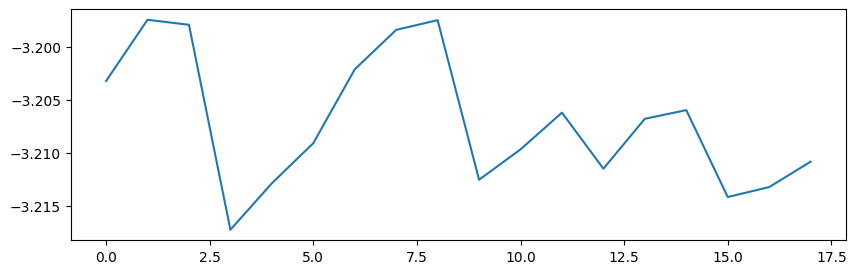

In [34]:
print("**Best parameters from grid search:**")
print(grid_search.best_params_)
print("Best score from grid search: %s"%grid_search.best_score_)
plt.figure(figsize=(10,3))
plt.plot(grid_search.cv_results_['mean_test_score'])
plt.show()

In [35]:
# print results for best estimator
y_pred = grid_search.best_estimator_.predict(X_test)
print("MSE = %s"%mean_squared_error(y_test.values,y_pred))
print("RMSE = %s"%root_mean_squared_error(y_test.values,y_pred))

MSE = 2.956549858655083
RMSE = 1.7194620840992927


## GradientBoost

In [36]:
gb_reg_pipe = make_pipeline(preprocess_pipeline, GradientBoostingRegressor(random_state=42, learning_rate=0.01,
                                                                          max_depth=5, min_samples_split=10, n_estimators=400,
                                                                          subsample=0.5))

gb_reg_pipe.fit(X_train, y_train)
y_pred_test = gb_reg_pipe.predict(X_test)
print(mean_squared_error(y_test.values,y_pred_test))
print(root_mean_squared_error(y_test.values,(y_pred_test)))

2.957329987300262
1.7196889216658524


### Hyperparameter GridSearch

In [37]:
gb_reg_pipe = make_pipeline(preprocess_pipeline, GradientBoostingRegressor(random_state=42))

param_grid = {
    'gradientboostingregressor__n_estimators': [200, 400],
    'gradientboostingregressor__learning_rate': [0.01,0.05],
    'gradientboostingregressor__min_samples_split': [5, 10],
    'gradientboostingregressor__subsample': [0.7, 0.5],
    'gradientboostingregressor__max_depth': [10, 5],
}


grid_search_gb = GridSearchCV(gb_reg_pipe, param_grid, cv=5, verbose=2, return_train_score=True, scoring = 'neg_mean_squared_error')
grid_search_gb.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END gradientboostingregressor__learning_rate=0.01, gradientboostingregressor__max_depth=10, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=200, gradientboostingregressor__subsample=0.7; total time=   8.4s
[CV] END gradientboostingregressor__learning_rate=0.01, gradientboostingregressor__max_depth=10, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=200, gradientboostingregressor__subsample=0.7; total time=   8.3s
[CV] END gradientboostingregressor__learning_rate=0.01, gradientboostingregressor__max_depth=10, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=200, gradientboostingregressor__subsample=0.7; total time=   8.4s
[CV] END gradientboostingregressor__learning_rate=0.01, gradientboostingregressor__max_depth=10, gradientboostingregressor__min_samples_split=5, gradientboostingregressor__n_estimators=

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('initial_preprocess',
                                                         PreTransform()),
                                                        ('column_transform',
                                                         ColumnTransformer(transformers=[('multi_cat',
                                                                                          MultiCatTransform(),
                                                                                          ['Employment',
                                                                                           'CodingActivities',
                                                                                           'LearnCode',
                                                                                           'BuyNewTool',
                                                                                           'TechEndorse',
                                                                                           'LanguageHaveWorkedWith',
                                                                                           'NEWCollabToolsHaveWorkedWith',
                                                                                           'OfficeStackSyncHaveWorkedW...
                                        GradientBoostingRegressor(random_state=42))]),
             param_grid={'gradientboostingregressor__learning_rate': [0.01,
                                                                      0.05],
                         'gradientboostingregressor__max_depth': [10, 5],
                         'gradientboostingregressor__min_samples_split': [5,
                                                                          10],
                         'gradientboostingregressor__n_estimators': [200, 400],
                         'gradientboostingregressor__subsample': [0.7, 0.5]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

**Best parameters from grid search:**
{'gradientboostingregressor__learning_rate': 0.01, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__min_samples_split': 5, 'gradientboostingregressor__n_estimators': 400, 'gradientboostingregressor__subsample': 0.5}
Best score from grid search: -3.143358195119622


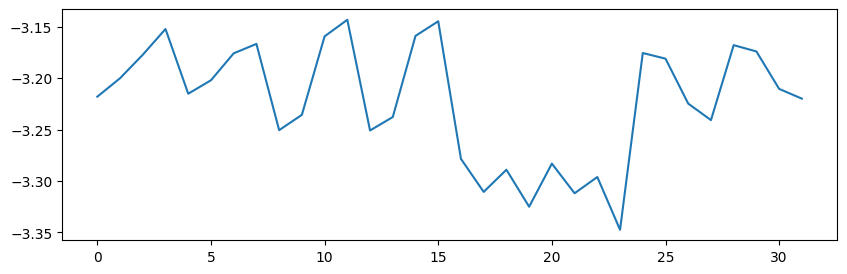

In [38]:
print("**Best parameters from grid search:**")
print(grid_search_gb.best_params_)
print("Best score from grid search: %s"%grid_search_gb.best_score_)
plt.figure(figsize=(10,3))
plt.plot(grid_search_gb.cv_results_['mean_test_score'])
plt.show()

In [45]:
y_pred_test = grid_search_gb.best_estimator_.predict(X_test)
print(mean_squared_error(y_test.values,y_pred_test))
print(root_mean_squared_error(y_test.values,(y_pred_test)))

2.964306211876337
1.721716065986589


In [44]:
# most important features
pd.Series(grid_search_gb.best_estimator_[1].feature_importances_, index=preprocess_pipeline[1].get_feature_names_out()).sort_values().tail(50)

one_hot_cat__Industry_Fintech                                 0.001575
one_hot_cat__RemoteWork_Hybrid                                0.001587
one_hot_cat__Industry_infrequent_sklearn                      0.001598
one_hot_cat__RemoteWork_Remote                                0.001615
one_hot_cat__SOAccount_No                                     0.001824
one_hot_cat__ProfessionalQuestion_AI-powered search (paid)    0.002401
ordinal_cat__Age                                              0.002641
ordinal_cat__Frequency_1                                      0.003182
one_hot_cat__Industry_Other:                                  0.003303
multi_cat__sum_CodingActivities                               0.004782
multi_cat__sum_Employment                                     0.004991
ordinal_cat__Frequency_2                                      0.005141
multi_cat__sum_TechEndorse                                    0.005474
ordinal_cat__SOVisitFreq                                      0.006103
multi_

# Result Evaluation

## Preprocess data

In [40]:
preprocess_pipeline.fit(X_train)
feature_names = preprocess_pipeline[-2].get_feature_names_out()
feature_names = pd.Series(feature_names).str.split("__").str[1]
X_test_transformed = pd.DataFrame(preprocess_pipeline.transform(X_test),columns=feature_names)
print(len(feature_names))

69


## RF Feature Importance

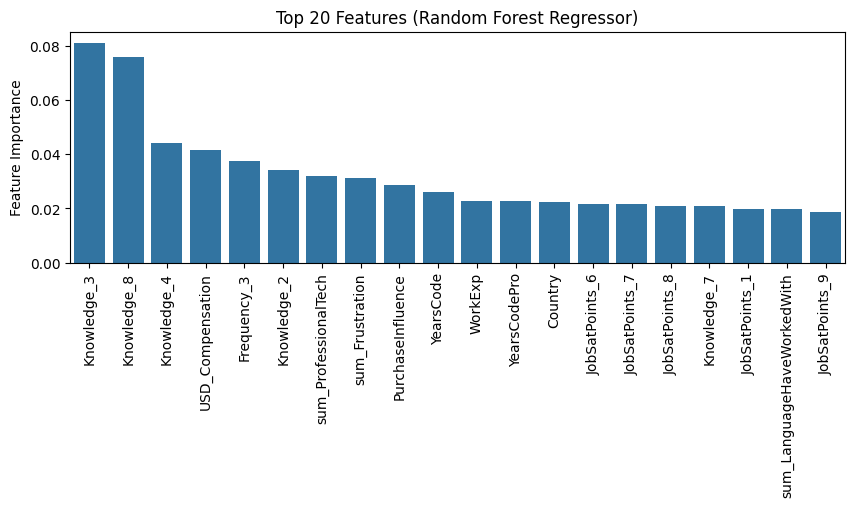

In [41]:
rfrg = grid_search.best_estimator_[-1]#rf_reg_pipe[-1]
top20_features = pd.Series(rfrg.feature_importances_,index=feature_names).sort_values(ascending=False).head(20)
plt.figure(figsize=(10,3))
sns.barplot(data=top20_features)
plt.xticks(rotation='vertical')
plt.title("Top 20 Features (Random Forest Regressor)")
plt.ylabel('Feature Importance')
plt.show()

## SHAP

In [42]:
# Obtain SHAP values
explainer = shap.TreeExplainer(rfrg)
shap_values = explainer.shap_values(X_test_transformed)

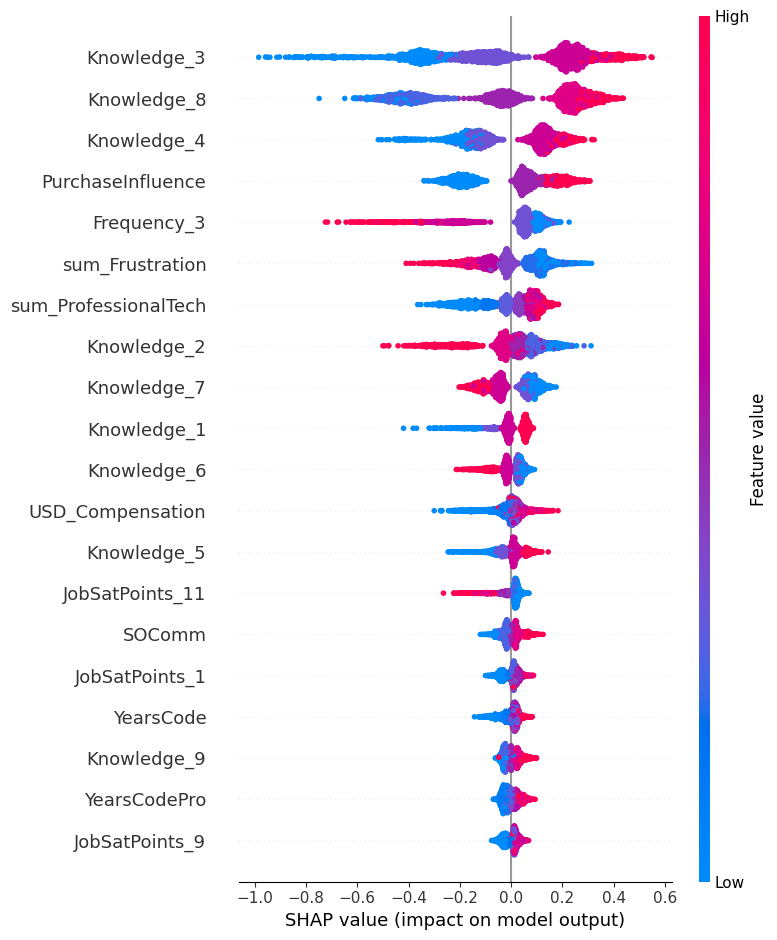

In [43]:
shap.summary_plot(shap_values, X_test_transformed )